# Wealth model with Mesa

## Introduction

### Setting up the model 

The model class holds the model-level attributes, manages the agents, and generally handles the global level of our model. Both the model and agent classes are child classes of Mesa’s generic `Model` and `Agent` classes.

In [2]:
from mesa import Agent, Model

class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)

### Adding the scheduler

The scheduler is a special model component which controls the order in which agents are activated. For example, all the agents may activate in the same order every step; their order might be shuffled; we may try to simulate all the agents acting at the same time; and more. Mesa offers a few different built-in scheduler classes, with a common interface. That makes it easy to change the activation regime a given model uses, and see whether it changes the model behavior. This may not seem important, but scheduling patterns can have an impact on your results [Comer2014].

For now, let’s use one of the simplest ones: RandomActivation, which activates all the agents once per step, in random order. Every agent is expected to have a step method. The step method is the action the agent takes when it is activated by the model schedule. We add an agent to the schedule using the add method; when we call the schedule’s step method, the model shuffles the order of the agents, then activates and executes each agent’s step method.

In [5]:
from mesa import Agent, Model
from mesa.time import RandomActivation

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        # The agent's step will go here.
        # For demonstration purposes we will print the agent's unique_id
        print ("Hi, I am agent " + str(self.unique_id) + ", I have a wealth of " + str(self.wealth) + ".")

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()

In [6]:
empty_model = MoneyModel(10)
empty_model.step()

Hi, I am agent 6, I have a wealth of 1.
Hi, I am agent 3, I have a wealth of 1.
Hi, I am agent 7, I have a wealth of 1.
Hi, I am agent 2, I have a wealth of 1.
Hi, I am agent 0, I have a wealth of 1.
Hi, I am agent 4, I have a wealth of 1.
Hi, I am agent 8, I have a wealth of 1.
Hi, I am agent 1, I have a wealth of 1.
Hi, I am agent 5, I have a wealth of 1.
Hi, I am agent 9, I have a wealth of 1.


### Make agent give away money

Now we just need to have the agents do what we intend for them to do: check their wealth, and if they have the money, give one unit of it away to another random agent. To allow the agent to choose another agent at random, we use the `model.random` random-number generator. This works just like Python’s `random` module, but with a fixed seed set when the model is instantiated, that can be used to replicate a specific model run later.

The scheduler has an internal list of all the agents it is scheduled to activate.

In [7]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

In [9]:
model = MoneyModel(10)
for i in range(10):
    model.step()

### Plotting

(array([5., 0., 3., 0., 1., 0., 0., 0., 0., 1.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

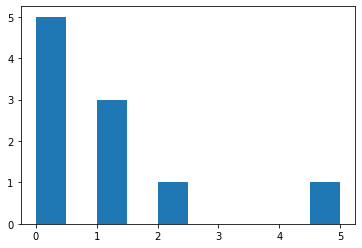

In [10]:
# For a jupyter notebook add the following line:
%matplotlib inline

# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

(array([435., 302., 160.,  58.,  28.,  17.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <BarContainer object of 6 artists>)

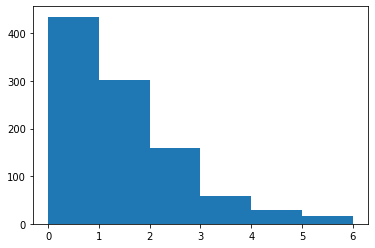

In [11]:
all_wealth = []
#This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth)+1))

### Adding space

Mesa currently supports two overall kinds of spaces: grid, and continuous. Grids are divided into cells, and agents can only be on a particular cell, like pieces on a chess board. Continuous space, in contrast, allows agents to have any arbitrary position. Both grids and continuous spaces are frequently toroidal, meaning that the edges wrap around, with cells on the right edge connected to those on the left edge, and the top to the bottom. This prevents some cells having fewer neighbors than others, or agents being able to go off the edge of the environment.

Mesa has two main types of grids: `SingleGrid` and `MultiGrid`. `SingleGrid` enforces at most one agent per cell; `MultiGrid` allows multiple agents to be in the same cell. Since we want agents to be able to share a cell, we use `MultiGrid`.

In [12]:
from mesa.space import MultiGrid

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

Under the hood, each agent’s position is stored in two ways: the agent is contained in the grid in the cell it is currently in, and the agent has a pos variable with an `(x, y)`  coordinate tuple. The `place_agent` method adds the coordinate to the agent automatically.

The grid object provides a `move_agent` method, which like you’d imagine, moves an agent to a given cell. That still leaves us to get the possible neighboring cells to move to. We use the grid’s built-in `get_neighborhood` method, which returns all the neighbors of a given cell. This method can get two types of cell neighborhoods: Moore (includes all 8 surrounding squares), and Von Neumann(only up/down/left/right). It also needs an argument as to whether to include the center cell itself as one of the neighbors.

We can get the contents of one or more cells using the grid’s `get_cell_list_contents method`, or by accessing a cell directly. The method accepts a list of cell coordinate tuples, or a single tuple if we only care about one cell.

In [17]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()
        
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1


In [18]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

Now let’s use matplotlib and numpy to visualize the number of agents residing in each cell. To do that, we create a numpy array of the same size as the grid, filled with zeros. Then we use the grid object’s `coord_iter()` feature, which lets us loop over every cell in the grid, giving us each cell’s coordinates and contents in turn.

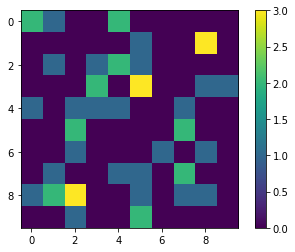

In [19]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

# If running from a text editor or IDE, remember you'll need the following:
# plt.show()

### Collecting Data

Since one of the main goals of agent-based modeling is generating data for analysis, Mesa provides a class which can handle data collection and storage for us and make it easier to analyze.

The data collector stores three categories of data: model-level variables, agent-level variables, and tables (which are a catch-all for everything else). Model- and agent-level variables are added to the data collector along with a function for collecting them. Model-level collection functions take a model object as an input, while agent-level collection functions take an agent object as an input. Both then return a value computed from the model or each agent at their current state. When the data collector’s `collect` method is called, with a model object as its argument, it applies each model-level collection function to the model, and stores the results in a dictionary, associating the current value with the current step of the model. Similarly, the method applies each agent-level collection function to each agent currently in the schedule, associating the resulting value with the step of the model, and the agent’s `unique_id`

In [20]:
from mesa.datacollection import DataCollector

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [21]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

<AxesSubplot:>

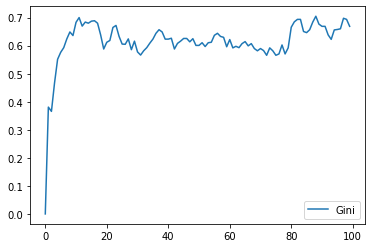

In [22]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [23]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

<AxesSubplot:>

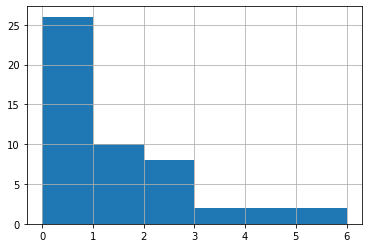

In [24]:
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

<AxesSubplot:xlabel='Step'>

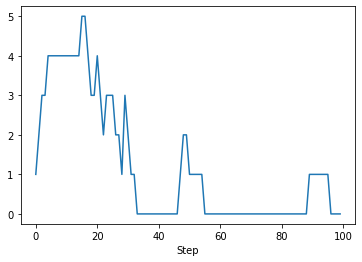

In [25]:
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

### Batch run

Instead of needing to write nested for-loops for each model, Mesa provides a `BatchRunner` class which automates it for you.

The `BatchRunner` also requires an additional variable `self.running` for the `MoneyModel` class. This variable enables conditional shut off of the model once a condition is met. In this example it will be set as `True` indefinitely.

In [26]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


We instantiate a `BatchRunner` with a model class to run, and two dictionaries: one of the fixed parameters (mapping model arguments to values) and one of varying parameters (mapping each parameter name to a sequence of values for it to take). The `BatchRunner` also takes an argument for how many model instantiations to create and run at each combination of parameter values, and how many steps to run each instantiation for. Finally, like the `DataCollector`, it takes dictionaries of model- and agent-level reporters to collect. Unlike the `DataCollector`, it won’t collect the data every step of the model, but only at the end of each run.



In [27]:
from mesa.batchrunner import BatchRunner

fixed_params = {"width": 10,
               "height": 10}
variable_params = {"N": range(10, 500, 10)}

batch_run = BatchRunner(MoneyModel,
                        variable_params,
                        fixed_params,
                        iterations=5,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini})
batch_run.run_all()



245it [00:26,  9.09it/s]


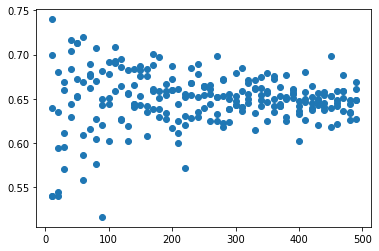

In [28]:
run_data = batch_run.get_model_vars_dataframe()
run_data.head()
plt.scatter(run_data.N, run_data.Gini)


In [29]:
#Get the Agent DataCollection
data_collector_agents = batch_run.get_collector_agents()

data_collector_agents[(10,2)]


Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1
...              ...
99   5             0
     6             0
     7             0
     8             1
     9             2

[1000 rows x 1 columns]

In [30]:
#Get the Model DataCollection.

data_collector_model = batch_run.get_collector_model()

data_collector_model[(10,1)]

,Gini
0,0.00
1,0.00
2,0.00
3,0.00
4,0.18
...,...
95,0.54
96,0.46
97,0.46
98,0.46


[Comer2014] Comer, Kenneth W. “Who Goes First? An Examination of the Impact of Activation on Outcome Behavior in AgentBased Models.” George Mason University, 2014. http://mars.gmu.edu/bitstream/handle/1920/9070/Comer_gmu_0883E_10539.pdf

## Advanced Features

### Adding visualization

First, a quick explanation of how Mesa’s interactive visualization works. Visualization is done in a browser window, using JavaScript to draw the different things being visualized at each step of the model. To do this, Mesa launches a small web server, which runs the model, turns each step into a JSON object (essentially, structured plain text) and sends those steps to the browser.

A visualization is built up of a few different modules: for example, a module for drawing agents on a grid, and another one for drawing a chart of some variable. Each module has a Python part, which runs on the server and turns a model state into JSON data; and a JavaScript side, which takes that JSON data and draws it in the browser window. Mesa comes with a few modules built in, and let you add your own as well.

#### Grid visualization

`CanvasGrid` works by looping over every cell in a grid, and generating a portrayal for every agent it finds. A portrayal is a dictionary (which can easily be turned into a JSON object) which tells the JavaScript side how to draw it. The only thing we need to provide is a function which takes an agent, and returns a portrayal object. Here’s the simplest one: it’ll draw each agent as a red, filled circle which fills half of each cell.

Now we create and launch the actual server. We do this with the following arguments:

- The model class we’re running and visualizing; in this case, `MoneyModel`.
- A list of module objects to include in the visualization; here, just `[grid]`
- The title of the model: “Money Model”
- Any inputs or arguments for the model itself. In this case, 100 agents, and height and width of 10.

Once we create the server, we set the port for it to listen on (you can treat this as just a piece of the URL you’ll open in the browser). Finally, when you’re ready to run the visualization, use the server’s `launch()` method.

In [ ]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer


def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "Color": "red",
                 "r": 0.5}
    return portrayal

grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)
server = ModularServer(MoneyModel,
                       [grid],
                       "Money Model",
                       {"N":100, "width":10, "height":10})
server.port = 8521 # The default
server.launch()

### Changing the agents

In [ ]:
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5}

    if agent.wealth > 0:
        portrayal["Color"] = "red"
        portrayal["Layer"] = 0
    else:
        portrayal["Color"] = "grey"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.2
    return portrayal


### Adding a chart

In [ ]:
from mesa.visualization.modules import ChartModule

chart = ChartModule([{"Label": "Gini",
                      "Color": "Black"}],
                    data_collector_name='datacollector')

server = ModularServer(MoneyModel,
                       [grid, chart],
                       "Money Model",
                       {"N":100, "width":10, "height":10})
